In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import copy
import os
import pprint
import functools
from pathlib import Path

import hydra
import duckdb
from omegaconf import OmegaConf
from einops import rearrange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.colors
import seaborn as sns
font_scale = 7
sns.set_theme(style='ticks', font_scale=font_scale, palette=sns.color_palette('Set2'),)
import sqlalchemy as sa
import marimo as mo
import seaborn as sns
import lightning.pytorch
import polars as pl
from tqdm import tqdm
import torch

from conf import conf
from dafm import datasets, models, plots, utils

In [3]:
duckdb.sql("""
attach '../runs.sqlite';
use runs;
""")

In [4]:
engine = conf.get_engine()
session = conf.sa.orm.Session(engine)
session.begin()

# Run queries

### Datasets

In [5]:
dataset_cols = ''.join(map(str.strip, """
    id,
    dataset_name,
    dataset_name_latex_short,
    time_step_count,
    time_step_count_drop_first,
    observe_every_n_time_steps,
""".splitlines()))

In [6]:
dataset_rows = duckdb.sql(f"""
    select {dataset_cols} from paper_lorenz96
    union
    select {dataset_cols} from paper_kuramoto_sivashinsky
--  union
--  select {dataset_cols} from paper_navier_stokes_dim_64
    union
    select {dataset_cols} from paper_navier_stokes_dim_256
""")
dataset_multiple = 3
assert len(dataset_rows) == dataset_multiple

### Models

In [7]:
model_cols = ''.join(map(str.strip, """
    id,
    model_name,
    sampling_time_step_count,
    hyperparameter1 as sigma_min,
    hyperparameter2 as lambda,
""".splitlines()))

In [8]:
model_rows = duckdb.sql(rf"""
    select {model_cols} from enff_ot
    union
    select {model_cols} from enff_f2p
""")
model_multiple = 2
assert duckdb.sql('select count(distinct model_name) from model_rows').fetchall()[0][0] == model_multiple

In [9]:
topk_hyperparameters = duckdb.sql("""
    select
        *
    from read_csv('../sweeps/topk_hyperparameters.csv')
    where true
    and k = 1
    and model_name in ('EnFF-OT', 'EnFF-F2P')
    and (
        dataset_name != 'NavierStokesDim256' and sampling_time_step_count = 5
        or
        dataset_name = 'NavierStokesDim256' and sampling_time_step_count = 10
    )
""")
topk_hyperparameters.show(max_width=125)

┌─────────────────────┬────────────┬──────────────────────┬───┬────────────────────┬──────────────────────┬───────┐
│    dataset_name     │ model_name │ sampling_time_step…  │ … │        crps        │     time_s_mean      │   k   │
│       varchar       │  varchar   │        int64         │   │       double       │        double        │ int64 │
├─────────────────────┼────────────┼──────────────────────┼───┼────────────────────┼──────────────────────┼───────┤
│ KuramotoSivashinsky │ EnFF-OT    │                    5 │ … │  2.642064401885672 │ 0.008961705499999795 │     1 │
│ Lorenz96Bao2024EnSF │ EnFF-OT    │                    5 │ … │  418.9476129150391 │  0.34903884901999815 │     1 │
│ KuramotoSivashinsky │ EnFF-F2P   │                    5 │ … │ 2.0785633004480473 │ 0.008697827060000378 │     1 │
│ Lorenz96Bao2024EnSF │ EnFF-F2P   │                    5 │ … │  437.9298669433594 │  0.36564879545999646 │     1 │
│ NavierStokesDim256  │ EnFF-F2P   │                   10 │ … │  6.43748

In [10]:
hyperparameters = duckdb.sql("""
    select
        dataset_name,
        model_name,
        hyperparameter_grid.sigma_min,
        hyperparameter_grid.lambda,
        topk_hyperparameters.hyperparameter1 = hyperparameter_grid.sigma_min as is_optimal_sigma_min,
        topk_hyperparameters.hyperparameter2 = hyperparameter_grid.lambda as is_optimal_lambda,
    from topk_hyperparameters
    join (
        select
            *
        from sweep_enff_sigma_min
        cross join sweep_enff_lambda
    ) as hyperparameter_grid on (
        topk_hyperparameters.hyperparameter1 = hyperparameter_grid.sigma_min
        or
        topk_hyperparameters.hyperparameter2 = hyperparameter_grid.lambda
    )
""")
hyperparameter_pair_count = 17
assert len(hyperparameters) == (
    model_multiple  # models
    * hyperparameter_pair_count  # hyperparameter pairs
    * dataset_multiple  # datasets
)
hyperparameters

┌─────────────────────┬────────────┬───────────┬──────────────┬──────────────────────┬───────────────────┐
│    dataset_name     │ model_name │ sigma_min │    lambda    │ is_optimal_sigma_min │ is_optimal_lambda │
│       varchar       │  varchar   │  double   │ decimal(4,3) │       boolean        │      boolean      │
├─────────────────────┼────────────┼───────────┼──────────────┼──────────────────────┼───────────────────┤
│ KuramotoSivashinsky │ EnFF-OT    │       0.1 │        0.050 │ false                │ true              │
│ KuramotoSivashinsky │ EnFF-OT    │      0.01 │        0.050 │ false                │ true              │
│ KuramotoSivashinsky │ EnFF-OT    │     0.001 │        0.050 │ false                │ true              │
│ KuramotoSivashinsky │ EnFF-OT    │    0.0001 │        0.050 │ false                │ true              │
│ KuramotoSivashinsky │ EnFF-OT    │     1e-05 │        0.050 │ true                 │ true              │
│ KuramotoSivashinsky │ EnFF-OT    │ 

### General

In [11]:
rows = duckdb.sql("""
    select
        alt_id,
        rng_seed,
        dataset_rows.*,
        model_rows.*,
        is_optimal_sigma_min,
        is_optimal_lambda,
    from Conf
    join dataset_rows on Conf.Dataset = dataset_rows.id
    join model_rows on Conf.Model = model_rows.id
    join hyperparameters on (
        dataset_rows.dataset_name = hyperparameters.dataset_name
        and
        model_rows.model_name = hyperparameters.model_name
        and
        (model_rows.sigma_min, model_rows.lambda) = (hyperparameters.sigma_min, hyperparameters.lambda)
    )
    where true
    and rng_seed in (select * from rng_seed_test)
    and model_rows.sampling_time_step_count in (select * from sweep_sampling_time_step_count)
""")
rng_seed_multiple = duckdb.sql("select count(*) from rng_seed_test").fetchall()[0][0]
sampling_time_step_count_multiple = duckdb.sql('select count(*) from sweep_sampling_time_step_count').fetchall()[0][0]
multiple = (
    dataset_multiple
    * rng_seed_multiple
    * model_multiple
    * sampling_time_step_count_multiple
    * hyperparameter_pair_count
)
assert len(rows) == multiple, f'{len(rows) = } != {multiple}'

In [12]:
duckdb.sql("""
    select
        rng_seed,
        dataset_name,
        model_name,
        sampling_time_step_count,
        count(*) as num_rows
    from rows
    group by
        rng_seed,
        dataset_name,
        model_name,
        sampling_time_step_count,
    order by rng_seed, dataset_name, model_name desc, sampling_time_step_count
""")

┌───────────┬─────────────────────┬────────────┬──────────────────────────┬──────────┐
│ rng_seed  │    dataset_name     │ model_name │ sampling_time_step_count │ num_rows │
│   int64   │       varchar       │  varchar   │          int64           │  int64   │
├───────────┼─────────────────────┼────────────┼──────────────────────────┼──────────┤
│  19704671 │ KuramotoSivashinsky │ EnFF-OT    │                        5 │       17 │
│  19704671 │ KuramotoSivashinsky │ EnFF-OT    │                       10 │       17 │
│  19704671 │ KuramotoSivashinsky │ EnFF-OT    │                       20 │       17 │
│  19704671 │ KuramotoSivashinsky │ EnFF-OT    │                       50 │       17 │
│  19704671 │ KuramotoSivashinsky │ EnFF-OT    │                      100 │       17 │
│  19704671 │ KuramotoSivashinsky │ EnFF-F2P   │                        5 │       17 │
│  19704671 │ KuramotoSivashinsky │ EnFF-F2P   │                       10 │       17 │
│  19704671 │ KuramotoSivashinsky │ EnFF-F2

In [13]:
logged_metrics_file_paths = plots.get_logged_metrics_file_paths(rows)
duckdb.sql("""
set variable dataset_metrics_filepaths = (
    select list(path) from logged_metrics_file_paths where exists
)
""")

##### RMSE and CRPS    

In [14]:
observation_steps_back = 50
logged_metrics = duckdb.sql(f"""
    select rows.*, logs.*,
    from (
        select split(filename, '/')[-2] as alt_id, step, time_s, crps, rmse,
        from read_csv(getvariable(dataset_metrics_filepaths), filename=true, union_by_name=true)
    ) as logs
    join rows on rows.alt_id = logs.alt_id
    where true
    and (logs.step - time_step_count_drop_first - 1) % observe_every_n_time_steps == 0 -- include only analysis time steps
    and step > time_step_count - observe_every_n_time_steps * {observation_steps_back}
""").pl()
logged_metrics

alt_id,rng_seed,id,dataset_name,dataset_name_latex_short,time_step_count,time_step_count_drop_first,observe_every_n_time_steps,id_1,model_name,sampling_time_step_count,sigma_min,lambda,is_optimal_sigma_min,is_optimal_lambda,alt_id_1,step,time_s,crps,rmse
str,i64,i64,str,str,i64,i64,i64,i64,str,i64,f64,f64,bool,bool,str,i64,f64,f64,f64
"""6vzly1bl""",462133975,2,"""Lorenz96Bao2024EnSF""","""Lorenz '96""",1800,1000,10,926,"""EnFF-F2P""",20,0.00001,0.05,false,true,"""6vzly1bl""",1301,1.25415,177.261963,0.177622
"""6vzly1bl""",462133975,2,"""Lorenz96Bao2024EnSF""","""Lorenz '96""",1800,1000,10,926,"""EnFF-F2P""",20,0.00001,0.05,false,true,"""6vzly1bl""",1311,1.040677,176.957687,0.177253
"""6vzly1bl""",462133975,2,"""Lorenz96Bao2024EnSF""","""Lorenz '96""",1800,1000,10,926,"""EnFF-F2P""",20,0.00001,0.05,false,true,"""6vzly1bl""",1321,1.185197,176.126282,0.176377
"""6vzly1bl""",462133975,2,"""Lorenz96Bao2024EnSF""","""Lorenz '96""",1800,1000,10,926,"""EnFF-F2P""",20,0.00001,0.05,false,true,"""6vzly1bl""",1331,1.269027,175.435211,0.175647
"""6vzly1bl""",462133975,2,"""Lorenz96Bao2024EnSF""","""Lorenz '96""",1800,1000,10,926,"""EnFF-F2P""",20,0.00001,0.05,false,true,"""6vzly1bl""",1341,1.26751,174.004578,0.174182
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""pcbh13e0""",462133975,50,"""KuramotoSivashinsky""","""KS""",6000,2000,4,910,"""EnFF-OT""",5,0.001,0.05,false,true,"""pcbh13e0""",5981,0.0083,2.601009,0.081745
"""pcbh13e0""",462133975,50,"""KuramotoSivashinsky""","""KS""",6000,2000,4,910,"""EnFF-OT""",5,0.001,0.05,false,true,"""pcbh13e0""",5985,0.038674,2.600599,0.081728
"""pcbh13e0""",462133975,50,"""KuramotoSivashinsky""","""KS""",6000,2000,4,910,"""EnFF-OT""",5,0.001,0.05,false,true,"""pcbh13e0""",5989,0.009263,2.595768,0.081577


In [15]:
required_observation_step_count = duckdb.sql(f"""
    select
        dataset_name,
        max(observation_step_count) as required_observation_step_count,
    from (
        select
            dataset_name,
            count(*) as observation_step_count,
        from logged_metrics
        group by alt_id, dataset_name
    )
    group by dataset_name
""")
required_observation_step_count

┌─────────────────────┬─────────────────────────────────┐
│    dataset_name     │ required_observation_step_count │
│       varchar       │              int64              │
├─────────────────────┼─────────────────────────────────┤
│ Lorenz96Bao2024EnSF │                              50 │
│ KuramotoSivashinsky │                              50 │
│ NavierStokesDim256  │                              50 │
└─────────────────────┴─────────────────────────────────┘

In [16]:
failed_before_finish_cols = """
    alt_id,
    dataset_name,
    model_name,
"""
failed_before_finish = duckdb.sql(f"""
    select
        observation_steps_back.*,
    from (
        select
            {failed_before_finish_cols}
            count(*) as observation_step_count,
        from logged_metrics
        group by {failed_before_finish_cols}
    ) as observation_steps_back
    join required_observation_step_count
    on observation_steps_back.dataset_name = required_observation_step_count.dataset_name
    and observation_steps_back.observation_step_count < required_observation_step_count.required_observation_step_count
    order by observation_steps_back.dataset_name, model_name desc, observation_step_count
""")
failed_before_finish

┌──────────┬────────────────────┬────────────┬────────────────────────┐
│  alt_id  │    dataset_name    │ model_name │ observation_step_count │
│ varchar  │      varchar       │  varchar   │         int64          │
├──────────┼────────────────────┼────────────┼────────────────────────┤
│ rr7d8bi3 │ NavierStokesDim256 │ EnFF-F2P   │                     18 │
│ uq2n527n │ NavierStokesDim256 │ EnFF-F2P   │                     32 │
│ b74tk20k │ NavierStokesDim256 │ EnFF-F2P   │                     49 │
└──────────┴────────────────────┴────────────┴────────────────────────┘

In [17]:
logged_metrics = duckdb.sql("""
    select *
    from logged_metrics
    where alt_id not in (select alt_id from failed_before_finish)
""")

In [18]:
duckdb.sql("""
    select
        dataset_name, model_name, sampling_time_step_count, count(*) as 'Num. Failed',
    from rows
    where alt_id not in (select alt_id from logged_metrics)
    group by dataset_name, model_name, sampling_time_step_count
    order by dataset_name, model_name desc, sampling_time_step_count
""")

┌─────────────────────┬────────────┬──────────────────────────┬─────────────┐
│    dataset_name     │ model_name │ sampling_time_step_count │ Num. Failed │
│       varchar       │  varchar   │          int64           │    int64    │
├─────────────────────┼────────────┼──────────────────────────┼─────────────┤
│ KuramotoSivashinsky │ EnFF-OT    │                        5 │          30 │
│ KuramotoSivashinsky │ EnFF-OT    │                       10 │           3 │
│ KuramotoSivashinsky │ EnFF-F2P   │                        5 │          30 │
│ KuramotoSivashinsky │ EnFF-F2P   │                       10 │          10 │
│ Lorenz96Bao2024EnSF │ EnFF-OT    │                        5 │          10 │
│ Lorenz96Bao2024EnSF │ EnFF-F2P   │                        5 │          25 │
│ NavierStokesDim256  │ EnFF-OT    │                        5 │          35 │
│ NavierStokesDim256  │ EnFF-OT    │                       10 │           3 │
│ NavierStokesDim256  │ EnFF-F2P   │                        5 │ 

In [19]:
group_by = """
    -- alt_id,
    -- rng_seed,
    dataset_name,
    model_name,
    sampling_time_step_count,
    is_optimal_sigma_min,
    is_optimal_lambda,
    sigma_min,
    lambda,
"""
logged_metrics_means = duckdb.sql(f"""
    select
        {group_by}
        mean(time_s) as time_s_mean,
        mean(rmse) as rmse,
        mean(crps) as crps,
    from logged_metrics
    group by
        {group_by}
""")
logged_metrics_means.show(max_width=125)

┌─────────────────────┬────────────┬──────────────────────┬───┬─────────────────────┬────────────────────┐
│    dataset_name     │ model_name │ sampling_time_step…  │ … │        rmse         │        crps        │
│       varchar       │  varchar   │        int64         │   │       double        │       double       │
├─────────────────────┼────────────┼──────────────────────┼───┼─────────────────────┼────────────────────┤
│ NavierStokesDim256  │ EnFF-OT    │                   20 │ … │ 0.14890872406959535 │  65.20644293212891 │
│ KuramotoSivashinsky │ EnFF-OT    │                   20 │ … │  0.1368882159722989 │  4.380260586503774 │
│ Lorenz96Bao2024EnSF │ EnFF-OT    │                   10 │ … │ 0.37897628831863406 │ 324.74664428710935 │
│ KuramotoSivashinsky │ EnFF-OT    │                   10 │ … │  1.9769158077662579 │  63.26066912433715 │
│ Lorenz96Bao2024EnSF │ EnFF-OT    │                   10 │ … │  1.0834321296215057 │ 1082.7457348632813 │
│ KuramotoSivashinsky │ EnFF-OT    │ 

In [20]:
logged_metrics_of_optimal = duckdb.sql("""
    select
        dataset_name,
        model_name,
        sampling_time_step_count,
        rmse,
        crps,
    from logged_metrics_means
    where true
    and is_optimal_sigma_min and is_optimal_lambda
    order by dataset_name, model_name desc, sampling_time_step_count
""")
logged_metrics_of_optimal

┌─────────────────────┬────────────┬──────────────────────────┬──────────────────────┬────────────────────┐
│    dataset_name     │ model_name │ sampling_time_step_count │         rmse         │        crps        │
│       varchar       │  varchar   │          int64           │        double        │       double       │
├─────────────────────┼────────────┼──────────────────────────┼──────────────────────┼────────────────────┤
│ KuramotoSivashinsky │ EnFF-OT    │                        5 │  0.08126918470933776 │ 2.6004660443974035 │
│ KuramotoSivashinsky │ EnFF-OT    │                       10 │  0.04962551562539218 │ 1.5878413756683338 │
│ KuramotoSivashinsky │ EnFF-OT    │                       20 │   1.0306650623238487 │  32.98108329971063 │
│ KuramotoSivashinsky │ EnFF-OT    │                       50 │   1.6089940418953799 │  51.48759791429772 │
│ KuramotoSivashinsky │ EnFF-OT    │                      100 │   1.7412542295009028 │ 55.719921918273265 │
│ KuramotoSivashinsky │ EnFF

/home/ttransue/GitHub/Data-Assimilation-Flow-Matching/.venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 23.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ttransue/GitHub/Data-Assimilation-Flow-Matching/.venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 30.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ttransue/GitHub/Data-Assimilation-Flow-Matching/.venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ttransue/GitHub/Data-Assimilation-Flow-Matching/.venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 15.4% of the points cannot be placed; you may want to decrea

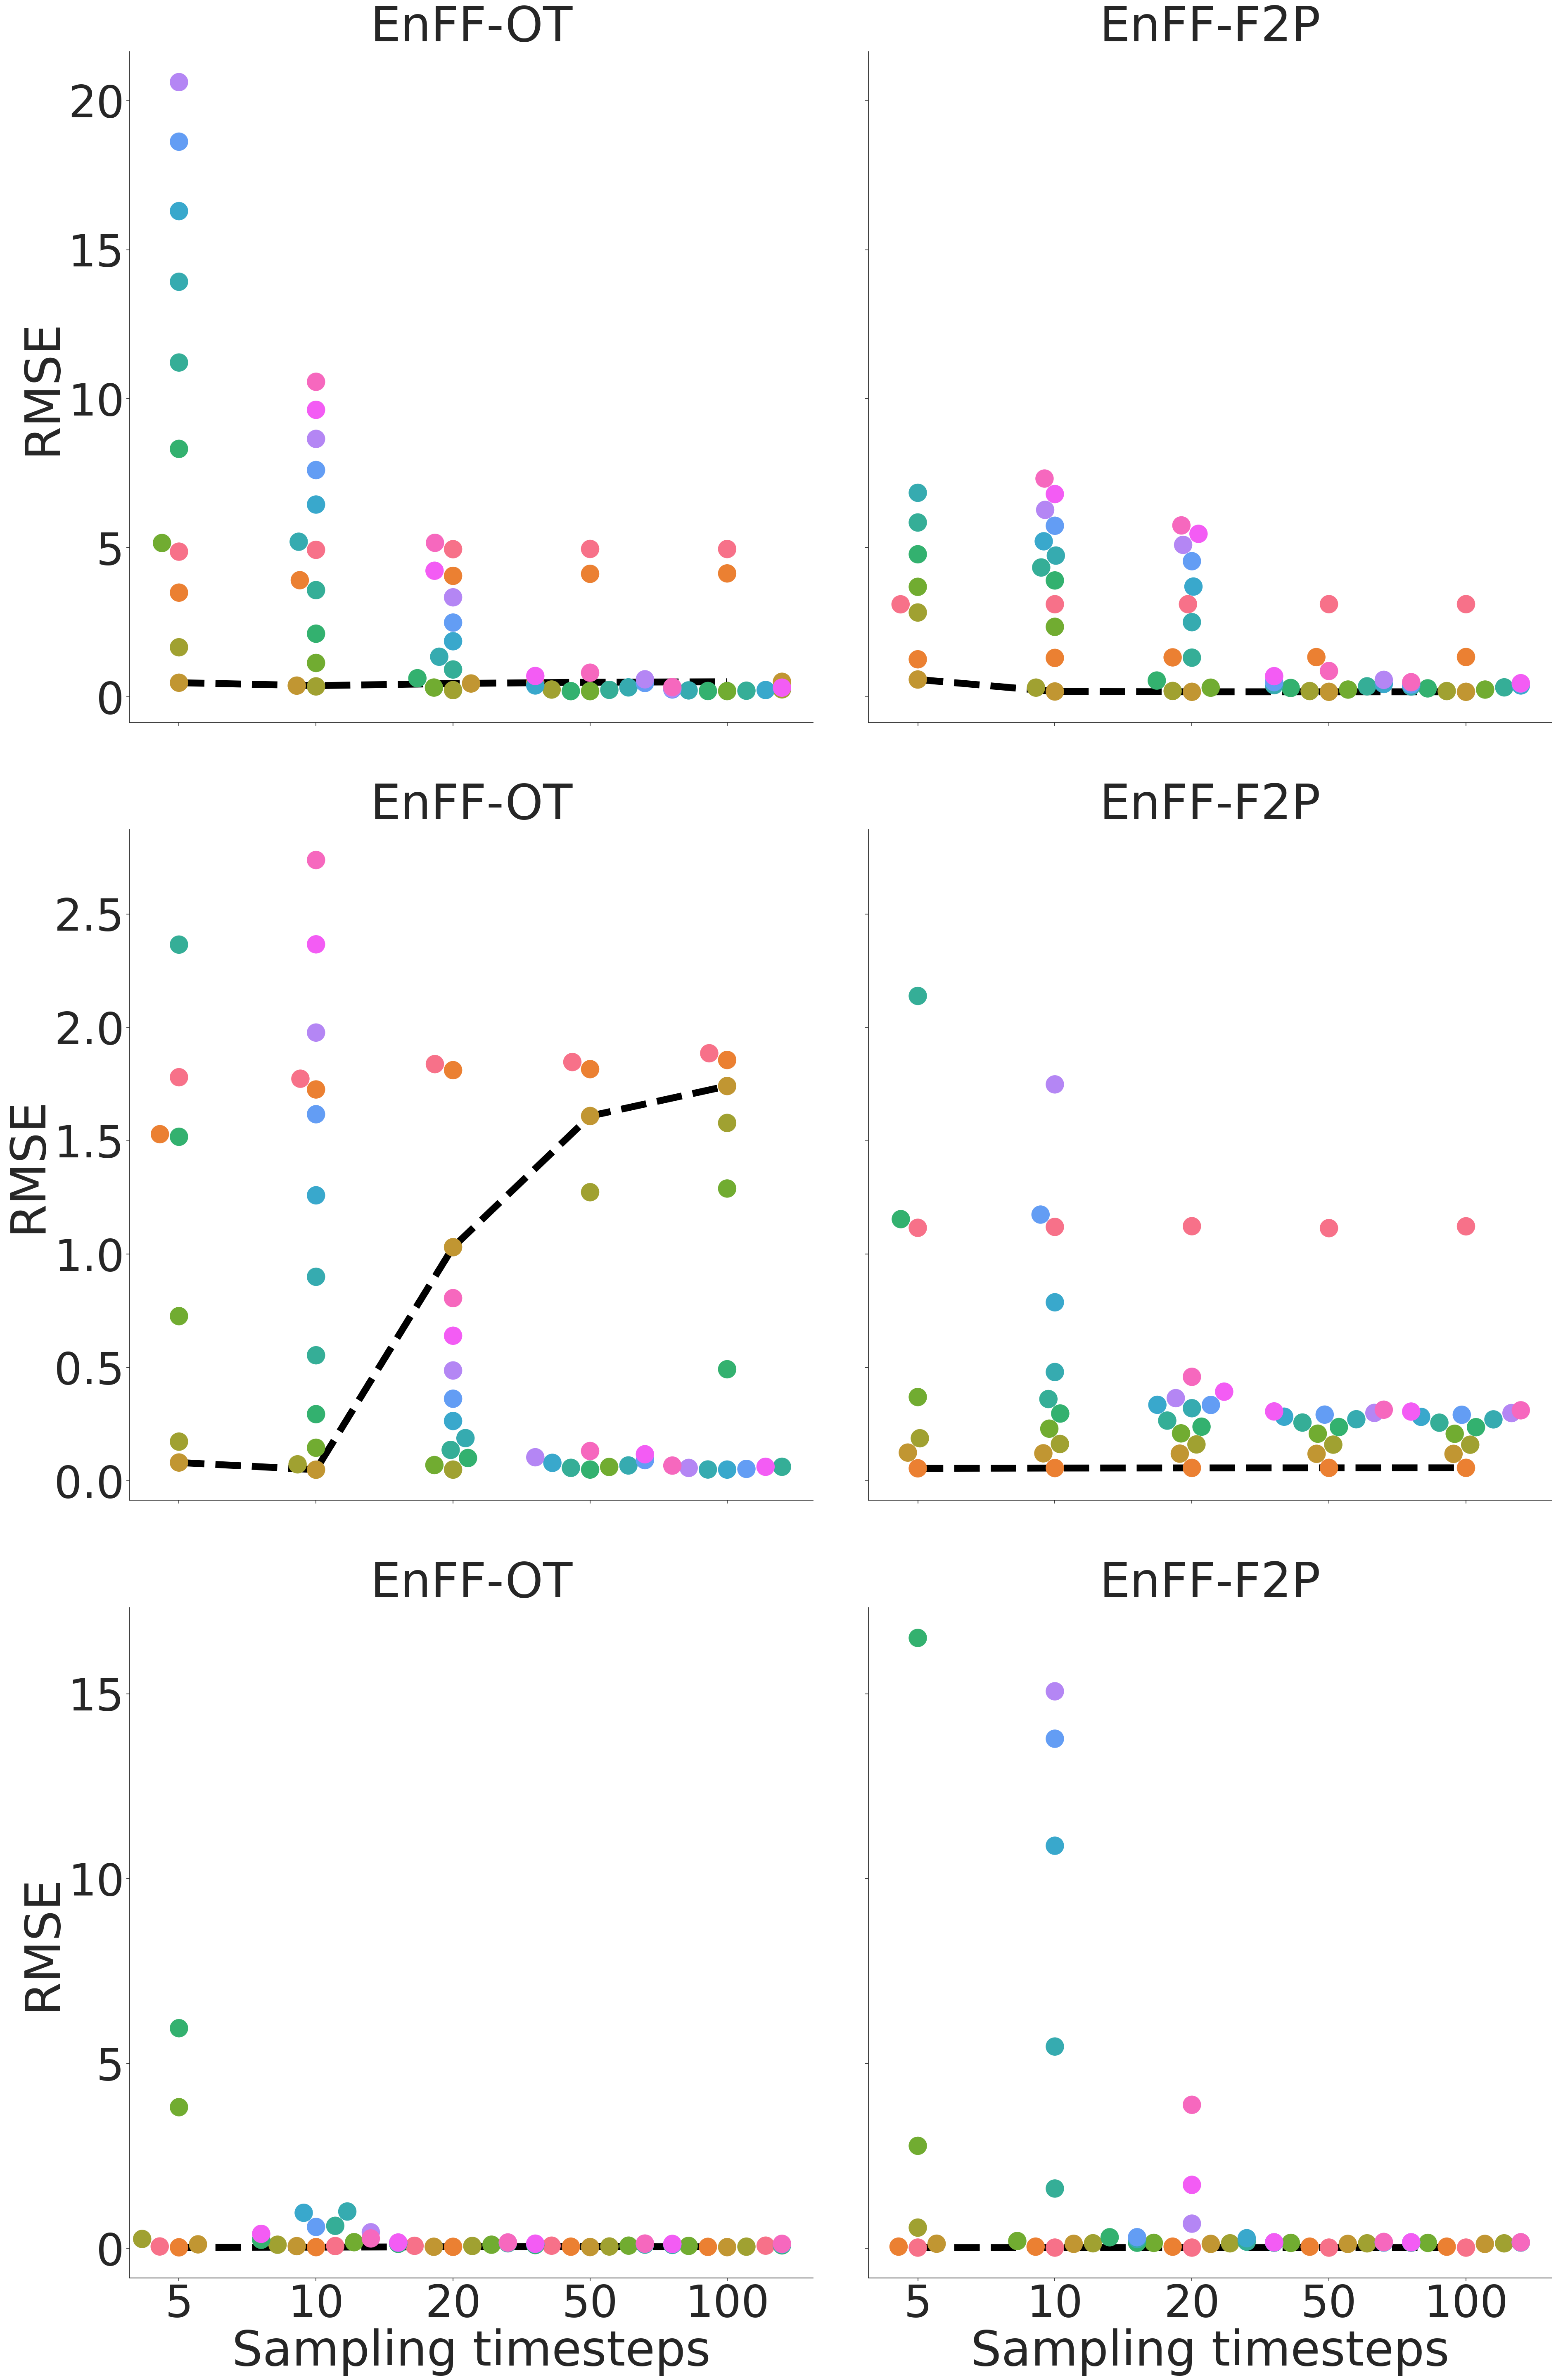

In [21]:
optimal_var, varying_var = 'sigma_min', 'lambda'
# optimal_var, varying_var = 'lambda', 'sigma_min'
plot_data = duckdb.sql(f"""
    select
        dataset_name,
        model_name,
        sampling_time_step_count,
        cast(sigma_min as varchar) as sigma_min,
        cast(lambda as varchar) as lambda,
        rmse,
        crps,
    from logged_metrics_means
    where is_optimal_{optimal_var}
    order by {varying_var}
""").df()
hue_order = plot_data[varying_var].unique()
y = 'rmse'
plot_metric = (
    sns.catplot(
        kind='swarm',
        data=plot_data,
        x='sampling_time_step_count',
        y=y,
        row='dataset_name',
        row_order=['Lorenz96Bao2024EnSF', 'KuramotoSivashinsky', 'NavierStokesDim256'],
        col='model_name',
        col_order=['EnFF-OT', 'EnFF-F2P'],
        hue=varying_var,
        legend=False,
        # s=512,
        s=1024,
        height=20,
        sharey='row',
    )
    .set(
        xlabel='Sampling timesteps',
        ylabel=y.upper(),
    )
    .set_titles('{col_name}')
)
for (row, col, _), data in plot_metric.facet_data():
    ax = plot_metric.axes[row, col]
    dataset_name = plot_metric.row_names[row]
    model_name = plot_metric.col_names[col]
    y_values = duckdb.sql(f"""
        select
            {y}
        from logged_metrics_of_optimal
        where true
        and dataset_name = {dataset_name!r}
        and model_name = {model_name!r}
    """).fetchnumpy()[y]
    ax.plot(ax.get_xticks(), y_values, c='black', lw=12, ls='--', marker='_')

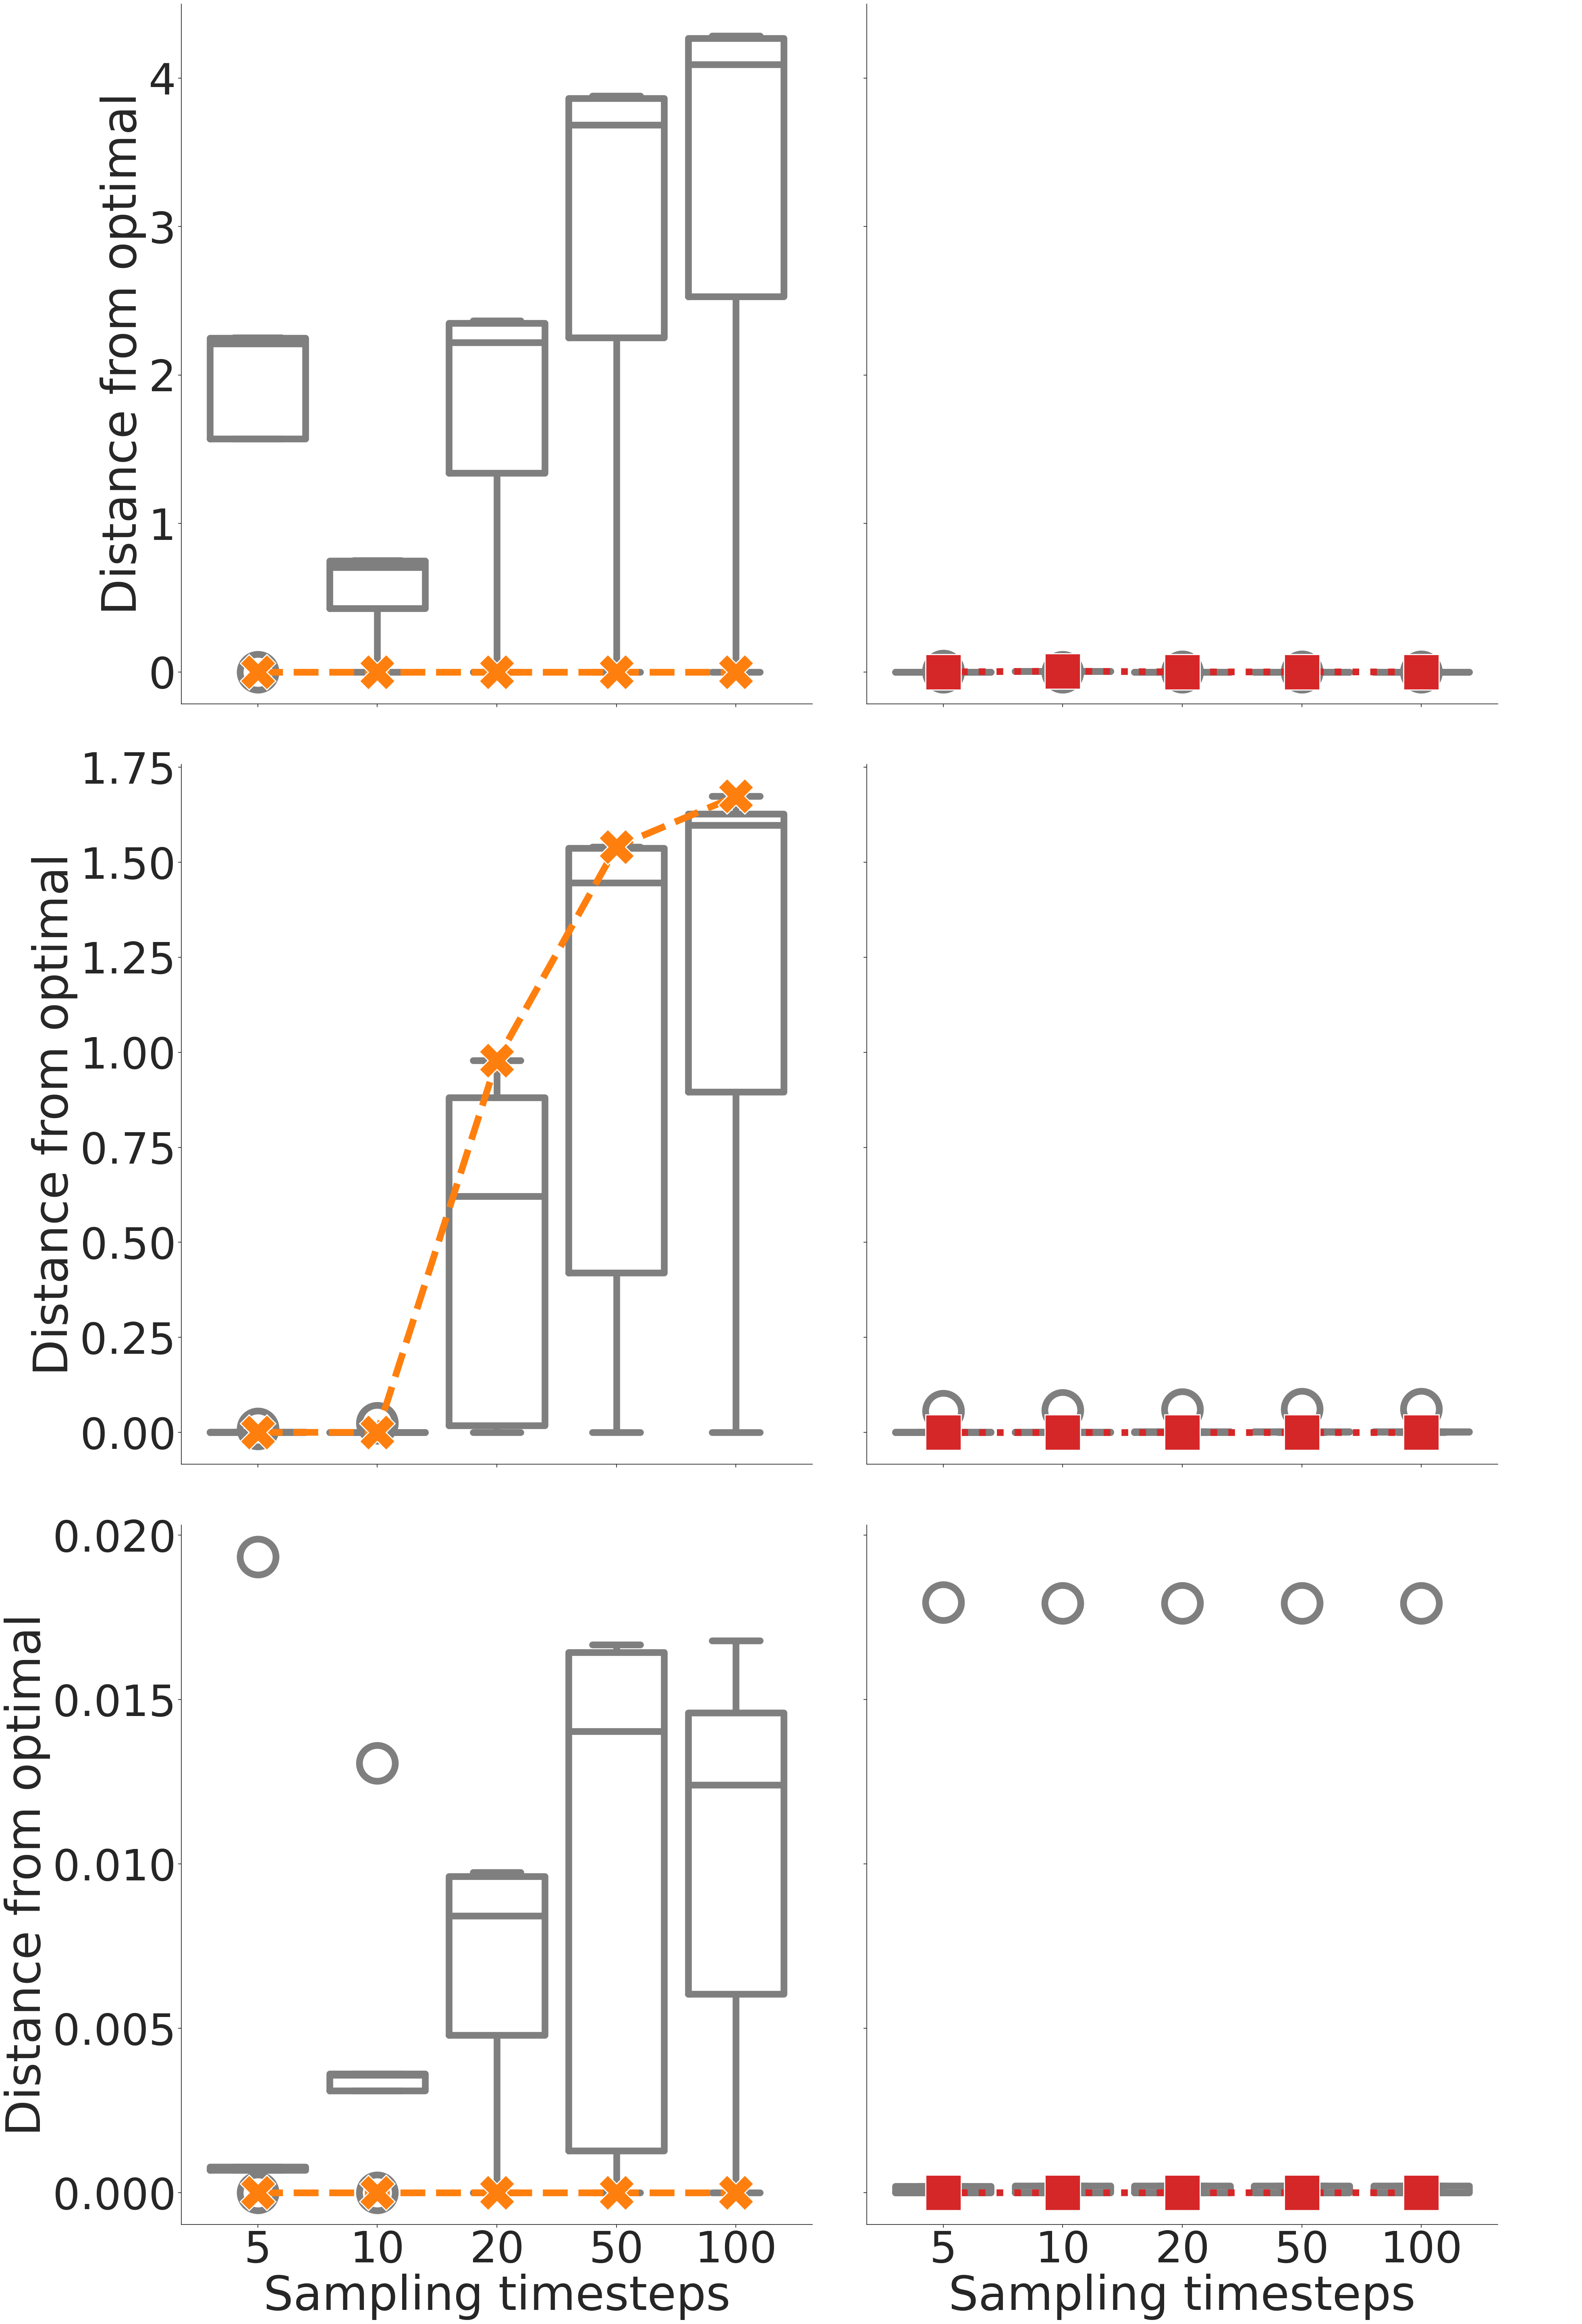

In [23]:
# optimal_var, varying_var = 'sigma_min', 'lambda'
optimal_var, varying_var = 'lambda', 'sigma_min'
plot_data = duckdb.sql(f"""
    with one_optimal as (
        select
            *
        from logged_metrics_means
        where is_optimal_{optimal_var}
        order by {varying_var}
    )
    select
        one_optimal.dataset_name,
        one_optimal.model_name,
        one_optimal.sampling_time_step_count,
        cast(one_optimal.sigma_min as varchar) as sigma_min,
        cast(one_optimal.lambda as varchar) as lambda,
        abs(one_optimal.rmse - best.rmse) as rmse_distance,
        abs(one_optimal.crps - best.crps) as crps_distance,
        one_optimal.is_optimal_{varying_var},
    from one_optimal
    join (
        select
            dataset_name,
            model_name,
            sampling_time_step_count,
            min(rmse) as rmse,
            min(crps) as crps,
        from one_optimal
        group by dataset_name, model_name, sampling_time_step_count
    ) as best on (
        one_optimal.dataset_name = best.dataset_name
        and
        one_optimal.model_name = best.model_name
        and
        one_optimal.sampling_time_step_count = best.sampling_time_step_count
    )
""").df()
hue_order = plot_data[varying_var].unique()
y = 'rmse_distance'
plot_metric = (
    sns.catplot(
        kind='box',
        # estimator='mean',
        # errorbar=lambda x: (x.loc[x > 0].min(), x.loc[x > 0].max()),
        data=plot_data,
        x='sampling_time_step_count',
        y=y,
        row='dataset_name',
        row_order=['Lorenz96Bao2024EnSF', 'KuramotoSivashinsky', 'NavierStokesDim256'],
        col='model_name',
        col_order=['EnFF-OT', 'EnFF-F2P'],
        # hue=varying_var,
        # legend=False,
        color='tab:gray',
        fill=False,
        height=20,
        linewidth=12,
        # err_kws=dict(
        #     linewidth=12,
        # ),
        fliersize=64,
        flierprops=dict(
            markeredgewidth=12,
        ),
        sharey='row',
    )
    .set(
        xlabel='Sampling timesteps',
        ylabel='Distance from optimal',
    )
    .set_titles('')
)
for (row, col, _), data in plot_metric.facet_data():
    ax = plot_metric.axes[row, col]
    abscissae = ax.get_xticks()
    ylim = ax.get_ylim()
    # ax.set_ylim(ylim[0] - sum(ylim) / 512, ylim[1])
    # ax = ax.twinx()
    dataset_name = plot_metric.row_names[row]
    model_name = plot_metric.col_names[col]
    y_values = duckdb.sql(f"""
        select
            data.{y}
        from logged_metrics_of_optimal
        join data on (
            logged_metrics_of_optimal.dataset_name = data.dataset_name
            and
            logged_metrics_of_optimal.model_name = data.model_name
            and
            logged_metrics_of_optimal.sampling_time_step_count = data.sampling_time_step_count
        )
        where true
        and data.is_optimal_{varying_var}
        order by logged_metrics_of_optimal.sampling_time_step_count
    """).fetchnumpy()[y]
    ax.plot(
        abscissae, y_values,
        c=plots.MODEL_PALETTE[model_name],
        lw=12, ls='--' if model_name == 'EnFF-OT' else ':',
        marker='X' if model_name == 'EnFF-OT' else 's',
        markersize=64, markeredgecolor='white', markeredgewidth=2,
        zorder=10,
    )
    # ax.set_ylim(*ylim)
plot_metric.tight_layout()

In [24]:
plot_metric.savefig(f'{y.upper()}.boxplot.vary_{varying_var}.pdf', pad_inches=.06)

('NavierStokesDim256', 50)